In [1]:
!pip install xmltodict
# !pip install -U segmentation-models
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=ba7e8f36695dd398f85b0173a10df0bdbe0eaf48242561ef99fc35b58f1ca68c
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


In [2]:
!apt install tesseract-ocr
!apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,504 kB/s)
Selecting previously unselect

In [3]:
import xmltodict
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageDraw
from PIL import ImagePath 
import numpy as np
import struct
import binascii
import os
from collections import Counter
from tqdm import tqdm
import pandas as pd
import json
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, LSTM, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from sklearn.model_selection import train_test_split

config = ConfigProto()
config.gpu_options.allow_growth = True
Image.LOAD_TRUNCATED_IMAGES = True

In [4]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,UpSampling2D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
import pytesseract
import shutil

In [5]:
!gdown --id "1HZY2Q6_weEOXesvAW2STCk6qEtEjyfTY"
!gdown --id "1UYvCJqQhJz1ps8b2QxyWTvBxc_JOr9uz"
!unzip -qq marmot_dataset.zip
!mkdir "models"

Downloading...
From: https://drive.google.com/uc?id=1HZY2Q6_weEOXesvAW2STCk6qEtEjyfTY
To: /content/marmot_dataset.zip
123MB [00:00, 142MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1UYvCJqQhJz1ps8b2QxyWTvBxc_JOr9uz
To: /content/CS2_Table_50_0030.hdf5
83.4MB [00:01, 74.7MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Aug 30 13:15:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Process Dataset


- We have manually combined the files in Marmots and Extended Marmots dataset and saved them into a final_dataset
- final_dataset folder contains 3 folders
 1. **table_data** : contains xml files which contain table bounding boxes. Taken from original Marmots dataset
 2. **col_data** : contains xml files which contain table bounding boxes. Taken from original Extended Marmots dataset
 3. **images**
- We will use these images and create column and image masks and store them in folders

In [ ]:
def hex_to_float(BBox):
  '''
  Input : List of hex numbers
  Output : List of integers
  Objective : Convert hex to int format
  '''
  conv_pound = [struct.unpack('!d', bytes.fromhex(t))[0] for t in BBox]
  res = [round((float(x)/72)*96) for x in conv_pound]
  return res

In [ ]:
img_paths = set(os.listdir("final_dataset/images"))
table_data_paths = set(os.listdir("final_dataset/table_data"))
col_data_paths = set(os.listdir("final_dataset/col_data"))

def get_image_dim(image_id):
  img = cv2.imread("final_dataset/images/"+image_id+".bmp")
  return (img.shape[0],img.shape[1])

def extract_col_mask(file_name,height=None,width=None):
  '''
  Input: file_name -> image_id without extension, dimensions of image
  Output: column_mask, list_of_bounding_boxes
  Objective: Read xml file and generate column masks. 
        If xml file not found, return blank mask
  '''

  if file_name+".xml" not in col_data_paths:
    return np.array(Image.new("L", (width,height))),[None]

  res = {}
  list_of_bounding_boxes = []
  try:
    with open("final_dataset/col_data/"+file_name+".xml","r") as f:
      res= xmltodict.parse(f.read())
  except:
      column_mask = np.array(Image.new("L", (height,width)))
      return column_mask

  ht = int(res["annotation"]["size"]["height"])
  wt = int(res["annotation"]["size"]["width"])
  column_mask = np.array(Image.new("L", (wt,ht))) # Image.new("",(width, height))
  for bbox in res["annotation"]["object"]:
    bbox = dict(bbox["bndbox"])
    list_of_bounding_boxes.append(dict(bbox))
    start_point = (int(bbox["xmin"]),int(bbox["ymin"]))
    end_point = (int(bbox["xmax"]),int(bbox["ymax"]))
    column_mask = cv2.rectangle(column_mask, start_point, end_point,(255,255,255),-1)

  return column_mask, list_of_bounding_boxes

- To extract the bounding boxes from the table mask in the marmots dataset. First we need to convert the hex numbers into integers first.
- The bonuding box attributes as relative to the CropBox and not the actual image. Marmots dataset first defines a CropBox which represents a the content area. The bounding boxes have attributes which are relative to this crop Box
- First we extract the CropBox cordinates and then we scale the bounding box cordinates so as to fit the actual page cordinates.
- Also we need to transfrom the bonuding box formats
 ![](https://drive.google.com/uc?export=view&id=1v--SlHMhXX3peM2-RkS1ZX3hRyjvzeRj)
 
- **Reference** : https://stackoverflow.com/questions/52824584/do-anyone-know-how-to-extract-image-coordinate-from-marmot-dataset/53377650
. This contains the code to convert from hex <-> int and also scaling the imaegs

In [ ]:
# Ref : https://stackoverflow.com/questions/52824584/do-anyone-know-how-to-extract-image-coordinate-from-marmot-dataset/53377650
def extract_table_mask(file_name, height=None, width=None):
  '''
  Input: file_name -> image_id without extension, dimensions of image
  Output: column_mask, list_of_bounding_boxes
  Objective: Read xml file and generate column masks. 
        If xml file not found, return blank mask
  '''
  if file_name+".xml" not in table_data_paths:
    return np.array(Image.new("L", (width,height))),[None]

  res = {}
  with open("/content/final_dataset/table_data/"+file_name+".xml") as f:
    res= xmltodict.parse(f.read())
  
  table_bboxes = []
  imgw = width
  imgh = height
  table_mask = np.array(Image.new("L", (imgw,imgh)))

  px0, py1, px1, py0 = hex_to_float(res["Page"]["@CropBox"].split())
  pw = abs(px1 - px0)
  ph = abs(py1 - py0)
  try:
    test = res["Page"]["Contents"]["Composites"]
  except:
    print(file_name)
    print(res)

  for box in res["Page"]["Contents"]["Composites"]:
    if box['@Label'] == 'TableBody':    
      # if one table then box is OrderedDict else its a list of OrderedDict
      if isinstance(box["Composite"], list):
        bboxes = box["Composite"]
      else:
        bboxes = [box["Composite"]]
      for single_box in bboxes:
        cords = single_box["@BBox"].split()
        x0, y1, x1, y0 = hex_to_float(cords)
        x0 = round(imgw*(x0 - px0)/pw)
        x1 = round(imgw*(x1 - px0)/pw)
        y0 = round(imgh*(py1 - y0)/ph)
        y1 = round(imgh*(py1 - y1)/ph)

        table_bboxes.append({"xmin":x0,"ymin":y0,"xmax":x1,"ymax":y1})
        start_point = (x0,y0)
        end_point = (x1,y1)
        table_mask= cv2.rectangle(table_mask, start_point, end_point,(255,0,0),-1)
  

  return table_mask, table_bboxes

In [ ]:
data = {"id":[], "col_boxes":[],"data":[],"dimensions":[],"img_path":[],"col_mask_path":[],"table_mask_path":[]}

In [ ]:
# Iterate through all files and then extract the table and column masks and save then 
file_names = [x[:-4] for x in os.listdir("final_dataset/images")]
for name in tqdm(file_names, position=0,  leave=True):
  ht, wt = get_image_dim(name)
  column_mask, col_boxes = extract_col_mask(name, ht, wt)
  table_mask, table_bboxes = extract_table_mask(name, ht, wt)
  
  data["id"].append(name)
  data["col_boxes"].append(col_boxes)
  data["table_boxes"].append(table_bboxes)
  data["dimensions"].append({"height":ht, "width":wt})
  data["col_mask_path"].append("final_dataset/col_masks/"+name+".bmp")
  data["table_mask_path"].append("final_dataset/table_masks/"+name+".bmp")
  data["img_path"].append("final_dataset/images"+name+".bmp")

In [ ]:
# Create a new dataframe with all the details extracted
# df = pd.DataFrame(data)
# df.to_csv("final_dataset/marmot.csv",index=None)

# df.to_csv("final_dataset/marmot.csv", index=None)
# !zip -r marmot_dataset.zip final_dataset/
# !cp "marmot_dataset.zip" "/content/drive/MyDrive/Datasets/CS2/"
# !cp marmot_dataset.zip "/content/drive/MyDrive/Datasets/CS2/"

Final Dataset CSV file
- **id** : image id
- **col_boxes** : List of table bounding box cordinates
- **table_boxes** : List of table bounding box cordinates
- **dimensions** : width and height of image
- **img_path** : path to image
- **col_mask_path** : path to column masked image
- **table_mask_path** : path to table masked image

# TF DATALOADER

In [8]:
df = pd.read_csv("final_dataset/marmot.csv")
df_train, df_test = train_test_split(df, test_size=0.1, random_state=10)
df[["id","img_path","col_mask_path","table_mask_path"]].head(5)

,id,img_path,col_mask_path,table_mask_path
0,10.1.1.160.686_7,final_dataset/images10.1.1.160.686_7.bmp,final_dataset/col_masks/10.1.1.160.686_7.bmp,final_dataset/table_masks/10.1.1.160.686_7.bmp
1,10.1.1.7.2122_8,final_dataset/images10.1.1.7.2122_8.bmp,final_dataset/col_masks/10.1.1.7.2122_8.bmp,final_dataset/table_masks/10.1.1.7.2122_8.bmp
2,10.1.1.6.2186_8,final_dataset/images10.1.1.6.2186_8.bmp,final_dataset/col_masks/10.1.1.6.2186_8.bmp,final_dataset/table_masks/10.1.1.6.2186_8.bmp
3,10.1.1.7.2112_8,final_dataset/images10.1.1.7.2112_8.bmp,final_dataset/col_masks/10.1.1.7.2112_8.bmp,final_dataset/table_masks/10.1.1.7.2112_8.bmp
4,10.1.1.6.2302_7,final_dataset/images10.1.1.6.2302_7.bmp,final_dataset/col_masks/10.1.1.6.2302_7.bmp,final_dataset/table_masks/10.1.1.6.2302_7.bmp


In [ ]:
img_path = "final_dataset/images/"
col_mask_path = "final_dataset/col_masks/"
table_mask_path = "final_dataset/table_masks/"
IMG_SIZE = 800
BATCH_SIZE = 4

def parse_image(filename):
  filename = filename + ".bmp"
  image = tf.io.read_file(img_path+filename)
  image = tf.image.decode_bmp(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  
  table_mask = tf.io.read_file(table_mask_path+filename)
  table_mask = tf.image.decode_bmp(table_mask, channels=0)
  table_mask = tf.image.resize(table_mask, [IMG_SIZE, IMG_SIZE])
  table_mask = table_mask/255.0

  col_mask = tf.io.read_file(col_mask_path+filename)
  col_mask = tf.image.decode_bmp(col_mask, channels=0)
  col_mask = tf.image.resize(col_mask, [IMG_SIZE, IMG_SIZE])
  col_mask = col_mask/255.0
  return image, {"col_decoder":col_mask, "table_decoder":table_mask}

def configure_for_performance(ds, batch_size):
  ds = ds.batch(batch_size)
  ds = ds.repeat()
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

def make_dataset(data, batch_size):
  filenames_ds = tf.data.Dataset.from_tensor_slices(data["id"].values)
  dataloader = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataloader
  dataloader = configure_for_performance(dataloader, batch_size)
  return dataloader, dataset

In [ ]:
TRAIN_STEPS_PER_EPOCH = len(df_train) // BATCH_SIZE                        
train_dataloader, train_dataset = make_dataset(df_train,4)
test_dataloader, test_dataset = make_dataset(df_test,4)

# Modelling

In [ ]:
from tensorflow.keras.applications import VGG19
tf.keras.backend.set_image_data_format('channels_last')


In [ ]:
class TableBranch(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__(name="col_decoder")
    self.conv1 = Conv2D(filters =128,kernel_size = (1, 1), activation = 'relu')
    self.upsample1 = UpSampling2D(size=(2, 2),interpolation='bilinear')
    self.upsample2 = UpSampling2D(size=(2, 2),interpolation='bilinear')
    self.upsample3 = UpSampling2D(size=(2,2))
    self.upsample4 = UpSampling2D(size=(2,2))
    self.convtraspose = Conv2DTranspose(2,kernel_size=3,strides=2,padding='same',activation='softmax')
  
  def call(self, input):
    input, pool4, pool3 = input[0],input[1], input[2]
    conv_1 = self.conv1(input)
    up_sample1 = self.upsample1(conv_1)
    concat_1 = Concatenate()([pool4,up_sample1])

    up_sample2 = self.upsample2(concat_1)
    concat_2 = Concatenate()([pool3,up_sample2])

    up_sample3 = self.upsample3(concat_2)
    up_sample4 = self.upsample4(up_sample3)
    final = self.convtraspose(up_sample4)
    return final

class ColumnBranch(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__(name="table_decoder")
    self.conv1 = Conv2D(filters =128,kernel_size = (1, 1), activation = 'relu')
    self.conv2 = Conv2D(filters =128,kernel_size = (1, 1), activation = 'relu')
    self.drop1 = Dropout(0.2)
    self.upsample1 = UpSampling2D(size=(2, 2),interpolation='bilinear')
    self.upsample2 = UpSampling2D(size=(2, 2),interpolation='bilinear')
    self.upsample3 = UpSampling2D(size=(2,2))
    self.upsample4 = UpSampling2D(size=(2,2))
    self.convtraspose = Conv2DTranspose(2,kernel_size=(3,3),strides=2,padding='same',activation='softmax')
  
  def call(self, input):
    input, pool4, pool3 = input[0],input[1], input[2]
    conv_1 = self.conv1(input)
    dropout = self.drop1(conv_1)
    conv_2 = self.conv2(dropout)

    up_sample1 = self.upsample1(conv_1)
    concat_1 = Concatenate()([pool4,up_sample1])

    up_sample2 = self.upsample2(concat_1)
    concat_2 = Concatenate()([pool3,up_sample2])
    up_sample3 = self.upsample3(concat_2)
    up_sample4 = self.upsample4(up_sample3)
    final = self.convtraspose(up_sample4)
    return final

In [ ]:
input_layer = Input((IMG_SIZE,IMG_SIZE,3),name="Input_Layer")
vgg_19= VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=input_layer,
    pooling=None, 
    classifier_activation="softmax"
)

for layer in vgg_19.layers:
    layer.trainable = False

pool_4_op = vgg_19.get_layer("block4_pool").output
pool_3_op = vgg_19.get_layer("block3_pool").output
x = Conv2D(128, (1,1), activation='relu',name="block_6_conv_1")(vgg_19.output)
x = Dropout(0.2)(x)
x = Conv2D(128, (1,1), activation='relu',name="block_6_conv_2")(x)
x = Dropout(0.2)(x)

table_output = TableBranch()([x,pool_4_op,pool_3_op])
column_output = ColumnBranch()([x,pool_4_op,pool_3_op])
model = Model(inputs=input_layer, outputs=[table_output,column_output])
# model.summary()

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 800, 800, 64) 1792        Input_Layer[0][0]                
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 800, 800, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 400, 400, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
# tf.keras.utils.plot_model(model)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
# opt = tf.keras.optimizers.Adam(learning_rate=0.01) 

losses = {
    "table_decoder":"sparse_categorical_crossentropy",
    "col_decoder": "sparse_categorical_crossentropy"
}

model.compile(loss=losses, optimizer=opt)

In [ ]:
#Model checkpoint callback
file_path = "models/CS2_1024_00_{epoch:04d}.hdf5"

cp_callback= tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    verbose=1,
    save_weights_only=True,
    period=5)

model.fit(
    train_dataloader,
    steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
    epochs=50,
    callbacks=[cp_callback]
)

In [ ]:
model.load_weights("/content/drive/MyDrive/Datasets/CS2/CS2_less_dropout_200_0050.hdf5")
# !cp "models/CS2_1024_00_0020.hdf5" "/content/drive/MyDrive/Datasets/CS2/"

In [ ]:
# tf.keras.models.save_model(model, './saved_model')
# my_tf_saved_model = tf.keras.models.load_model('./saved_model')

In [ ]:
!cp tablenet_model.zip "/content/drive/MyDrive/Datasets/CS2/"

In [ ]:
# given predicted boxes approximate the predicted rectangles
def fil_approx_boxes(img):
  cv2.imwrite("test.jpeg",img)
  img = cv2.imread("test.jpeg",0)
  img = cv2.medianBlur(img,5)
  img = cv2.GaussianBlur(img,(13,13),0)
  img = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)[1]

  # convert to grayscale thresholds and find contours
  _, threshold = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY_INV)
  contours,_ = cv2.findContours(threshold, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contours:
      # plot a bounding box around contours and fill it
      x,y,w,h = cv2.boundingRect(cnt)
      if x==0 or y==0:
          continue 
      # if cv2.contourArea(cnt) < 5000:
      #   continue
      cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),-1)
      
  # Remove small dots in image
  img = cv2.GaussianBlur(img,(13,13),0)
  img = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)[1]
  return img

In [ ]:
# predict table and column masks and display
def plot_res(img,masks=None,ind=0):

  res1, res2 = model.predict(np.array([img]))
  res1 =  np.expand_dims(np.argmax(res1[0], axis=-1), axis=-1)
  res2 = np.expand_dims(np.argmax(res2[0], axis=-1), axis=-1)
  pred_col = np.squeeze(np.where(res1==1,255,0))
  pred_table = np.squeeze(np.where(res2==1,255,0))

  if masks is None:
    return fil_approx_boxes(pred_table),fil_approx_boxes(pred_col)

  fig, ax = plt.subplots(1,6,figsize=(20,20))
  ax[0].imshow(np.squeeze(np.where(masks["table_decoder"]==1,255,0)))
  ax[0].title.set_text("Table Mask")
  ax[1].imshow(np.squeeze(np.where(masks["col_decoder"]==1,255,0)))
  ax[1].title.set_text("Column Mask")
  
  ax[2].imshow(pred_table)
  ax[2].title.set_text("Predicted Table Mask")
  ax[3].imshow(pred_col)
  ax[3].title.set_text("Predicted Column Mask")

  ax[4].imshow(fil_approx_boxes(pred_table))
  ax[4].title.set_text("Approximated Table Mask")
  ax[5].imshow(fil_approx_boxes(pred_col))
  ax[5].title.set_text("Approximated Column Mask")


  plt.show()
  return fil_approx_boxes(pred_table),fil_approx_boxes(pred_col)

def plot_masks(file_id):
  fig, ax = plt.subplots(1,3,figsize=(7,7))
  ax[0].imshow(cv2.imread("final_dataset/images/"+id+".bmp"))
  ax[0].title.set_text("Image")
  ax[1].imshow(cv2.imread("output/true/"+id+".bmp"))
  ax[1].title.set_text("Ground Truth Mask")
  ax[2].imshow(cv2.imread("output/pred/"+id+".jpeg"))
  ax[2].title.set_text("Predicted Mask")

## Images from train_dataset (SEEN SAMPLES)

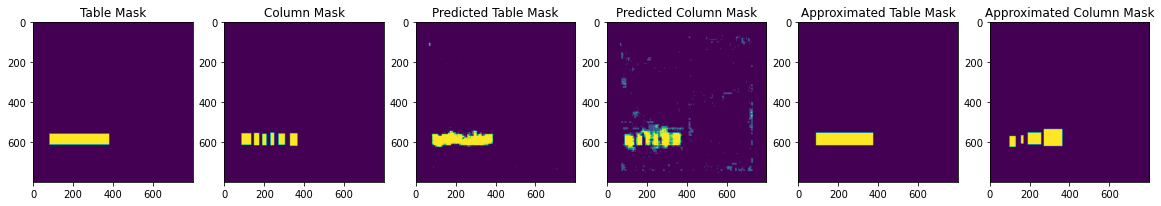

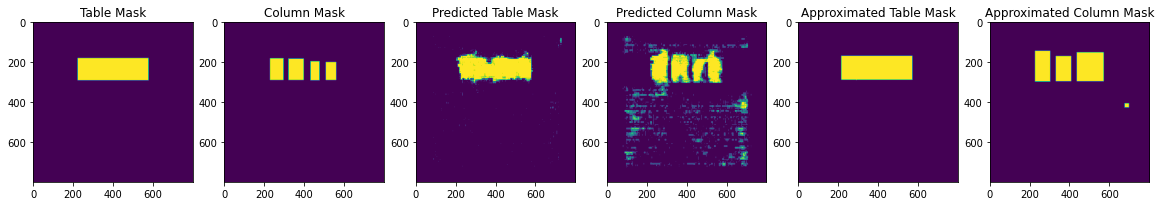

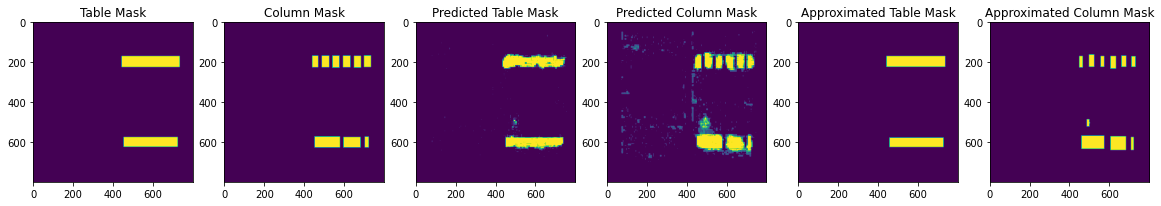

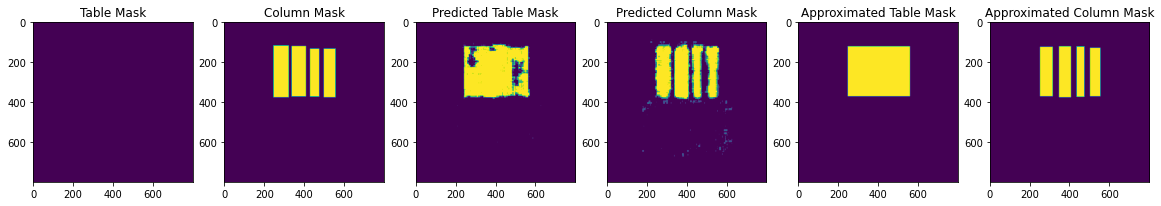

80


In [ ]:
# table auto predict : 40-45,45-50

count = 0
for img, mask in train_dataset.take(80):
  # print(count)
  count += 1
  if count > 45 and count<50:
    plot_res(img, mask, count) 

print(count)


## Images from test_dataset (UNSEEN SAMPLES)

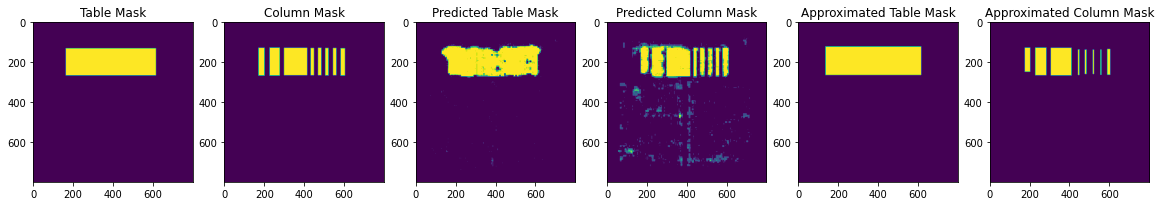

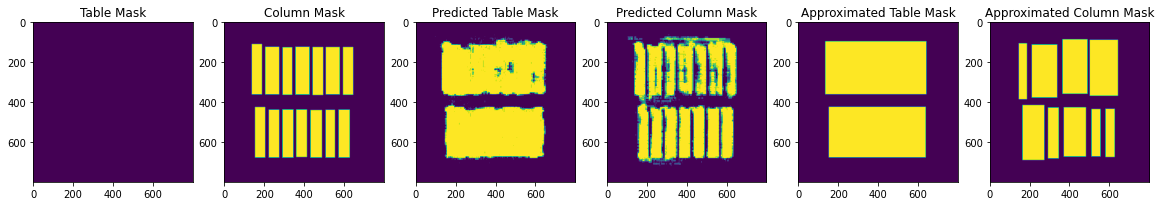

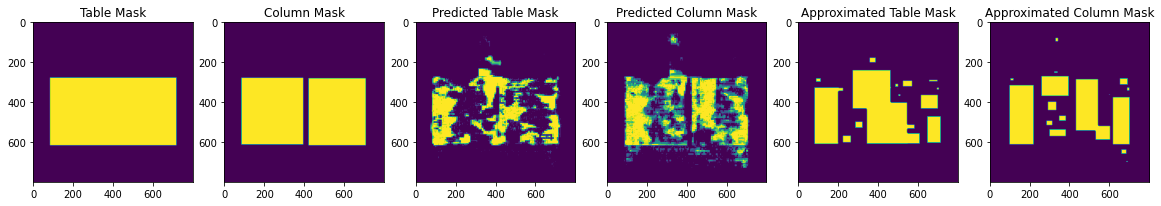

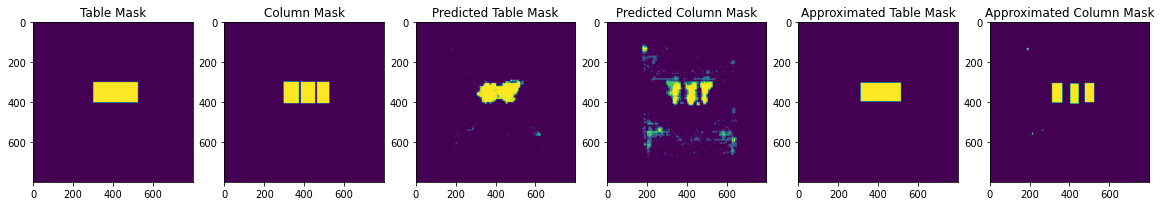

In [ ]:
count = 0
for img, mask in test_dataset.take(50):
  # print(count)
  count += 1
  if count > 17 and count<22:
    plot_res(img, mask,count) 


## OBSERVATIONS
- The model was trained for 100 epochs. After prediction we have defined a function called *fill_aprox_boxes* function, in which we use opencv functions to remove minor noises as well as trying to approximate the unevenly shaped rectangle shapes
- From predictions of on both train and test dataset samples, we can seee that our model predicts Table masks almost accurately. There are very few misclassifications. But, it doesnt properly predict the test dataset images which are unseen.
- We see that on test dataset(unseen images) our model still predicts table masks pretty well.
- **Interesting observation**: <br>
 - We had seen in EDA part that some images have column masks but no column masks (this was bcause it was not annotated). When we try to predict those images, we see that table region was predicted accurately even though for those image we didnt provide image masks.
 - This is becuase our model takes into account both column and table masks while predicting the masks.

## Predict table masks and extract text

In [ ]:
def predict_and_extract(file_path, output_file_name = "res.txt"):
  '''
  Steps done:
  1) Read image and resize it to (800,800)
  2) Predict table_masks using model
  3) Resize the table_masks to be same size as original image
  4) Extract text from only the table_region & save in a txt file
  '''
  
  img_path = file_path
  image = tf.io.read_file(img_path)
  org_image = tf.image.decode_bmp(image, channels=3)
  h,w = org_image.shape[0],org_image.shape[1]
  image = tf.image.resize(org_image, [IMG_SIZE, IMG_SIZE])
  pred_table, pred_col = plot_res(image,masks=None)

  # Create mask from predicted table_mask
  tab = np.where(pred_table == 0,0,1)
  mask = np.expand_dims(tab,axis=2)
  mask = np.concatenate((mask,mask,mask),axis=2)
  cv2.imwrite("mask.jpeg",mask)

  # resize mask to original image dimension (To get better results in tesseract)
  mask = cv2.resize(cv2.imread("mask.jpeg"), (w,h), interpolation = cv2.INTER_AREA)
  masked_img= org_image.numpy() * mask
  cv2.imwrite("org.jpeg",masked_img)

  data = pytesseract.image_to_string(Image.open('org.jpeg'), lang='eng')
  print("Extracted DATA:\n ",data)

  cv2_imshow(masked_img)

  file1 = open(output_file_name,"w")
  file1.write(data)
  file1.close()

  plt.show()

Extracted DATA:
  pGenenererm | NMroNrod nqunearent |

Extemal Entity

[nternal Entity | Logical Load
Resource: Queue: Block
Cour

Control Element r
Process Traffic Limit

Delay List Delay Lis
Condition Delay Lis
Load Ready List

User Managed List

 



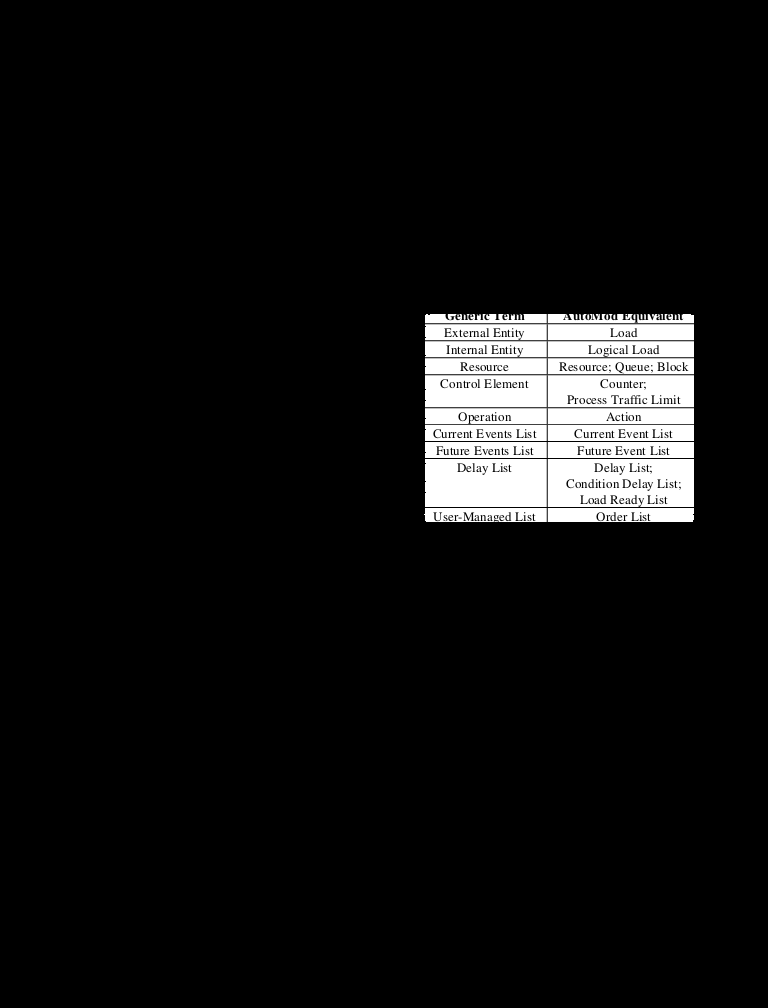

In [ ]:
predict_and_extract("/content/final_dataset/images/10.1.1.1.2071_4.bmp")

# Post Training Error Analysis

In [ ]:
!mkdir output
!mkdir output/true
!mkdir output/pred

In [ ]:
def predict_and_save(file_id, output_folder):
  '''
  Fetch the image from the file_id and predict masks
  Save the ground truth and predicted masks in the output_folder
  '''
  img_path = "/content/final_dataset/images/"+file_id+".bmp"
  gt_mask_path = "/content/final_dataset/table_masks/"+file_id+".bmp"
  output_mask_path = output_folder+"/pred/"+file_id+".jpeg" 

  true_path = output_folder+"/true/"
  !cp $gt_mask_path $true_path

  image = tf.io.read_file(img_path)
  org_image = tf.image.decode_bmp(image, channels=3)
  image = tf.image.resize(org_image, [IMG_SIZE, IMG_SIZE])
  pred_table, pred_col = plot_res(image,masks=None)
  h,w,_ = cv2.imread(gt_mask_path).shape 
  mask = cv2.resize(pred_table, (w,h), interpolation = cv2.INTER_AREA)
  cv2.imwrite(output_mask_path,mask)


In [ ]:
for id in tqdm(df["id"].values):
  predict_and_save(id, 'output')

100%|██████████| 532/532 [02:55<00:00,  3.02it/s]


## Check loss for each predictions
- We get the predicted masks for each image and save into separate folders
- We then calculate the IoU score foe the ground truth mask and the predicted mask
- We find that in cases where there were no tables (i.e mask is blank) we get IoU as NaN or 0. We ignore those cases for analysis
- We divide the samples into 3 categories based on the IoU score
  1. **Best** : IoU score > 0.7
  2. **Average** : IoU score between 0.4 and 0.7
  3. **Worst** : IoU score < 0.4

In [ ]:
# IoU calculation
result1 = cv2.imread("/content/output/true/10.1.1.1.2006_3.bmp")
result2 = cv2.imread("/content/output/pred/10.1.1.1.2006_3.jpeg")

data = []
for id in tqdm(df["id"].values):
  img1 = cv2.imread("output/true/"+id+".bmp")
  img2 = cv2.imread("output/pred/"+id+".jpeg")
  
  intersection = np.logical_and(img1, img2)
  union = np.logical_or(img1, img2)
  iou_score = np.sum(intersection) / np.sum(union)
  data.append((id,iou_score))


  0%|          | 0/532 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
100%|██████████| 532/532 [00:05<00:00, 90.07it/s]


In [ ]:
df_loss = pd.DataFrame(data=data, columns=["id","iou_score"])

# IoU is NaN or 0 for images with no tables/columns
df_nan = df_loss[(df_loss["iou_score"].isna()) | (df_loss["iou_score"] == 0)]

df_loss = df_loss.dropna() 
df_loss = df_loss[df_loss["iou_score"]>0]
df_loss = df_loss.sort_values(by="iou_score",ascending=False)
df_loss.head()

,id,iou_score
49,10.1.1.160.660_6,0.988829
83,10.1.1.10.2577_6,0.985660
199,10.1.1.7.2101_27,0.982160
321,10.1.1.160.669_3,0.978757
60,10.1.1.1.2107_8,0.977200


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


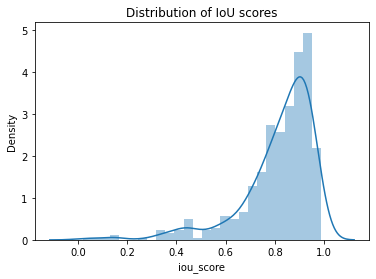

In [ ]:
sns.distplot(df_loss["iou_score"])
plt.title("Distribution of IoU scores")
percentile_25 = np.percentile(df_loss["iou_score"],25)
percentile_75 = np.percentile(df_loss["iou_score"],75)

In [ ]:
df_best = df_loss[df_loss["iou_score"] > 0.7]
df_worst = df_loss[df_loss["iou_score"] < 0.3]
df_avg = df_loss[(df_loss["iou_score"] > 0.4) & ((df_loss["iou_score"] < 0.7))]

print("Best IoU score : ",max(df_loss["iou_score"].values))
print("Best IoU score : ",min(df_loss["iou_score"].values))

print("No of images in Best cat ",df_best.shape[0])
print("No of images in Avg preds cat:",df_avg.shape[0])
print("No of images in Worst preds cat:",df_worst.shape[0])

Best IoU score :  0.9888288320403534
Best IoU score :  0.018779342723004695
No of images in Best cat  407
No of images in Avg preds cat: 58
No of images in Worst preds cat: 6


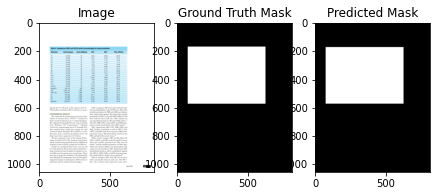

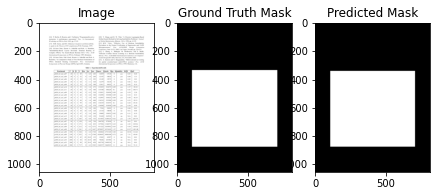

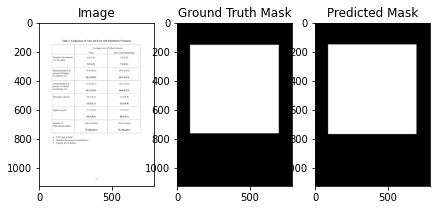

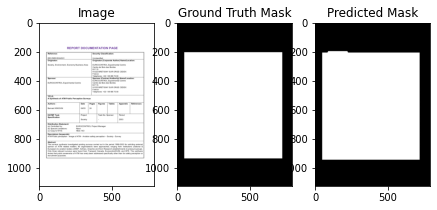

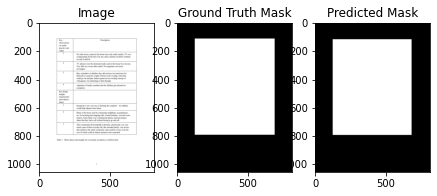

In [ ]:
# Best cases
for id in df_best.iloc[:5]["id"].values:
  plot_masks(id)

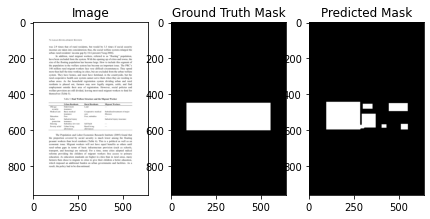

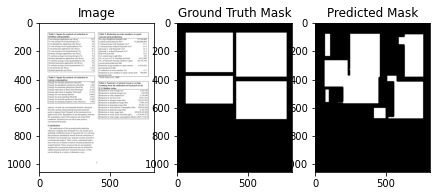

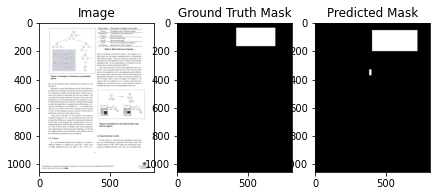

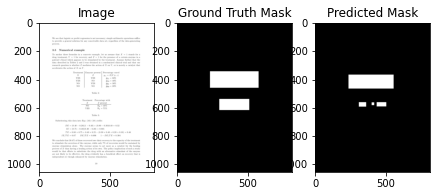

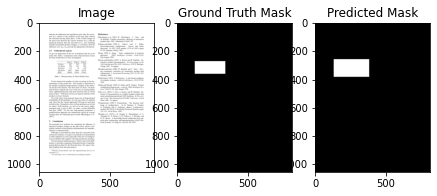

In [ ]:
# Average cases
for id in df_avg.iloc[30:35]["id"].values:
  plot_masks(id)

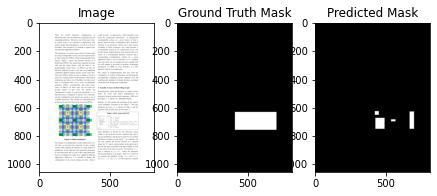

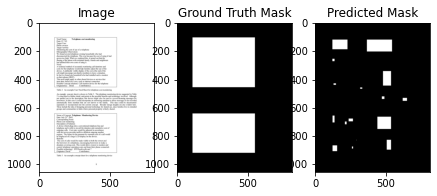

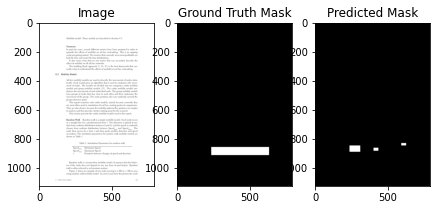

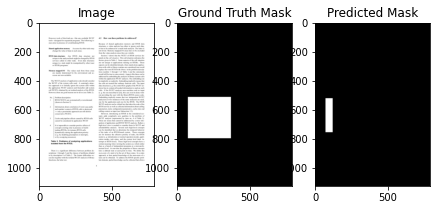

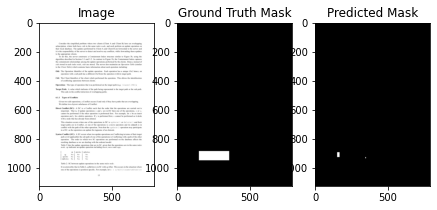

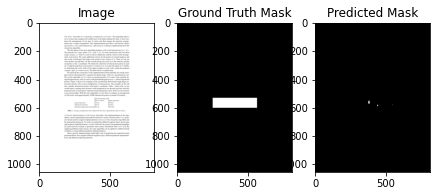

In [ ]:
# Worst cases
for id in df_worst.iloc[:6]["id"].values:
  plot_masks(id)

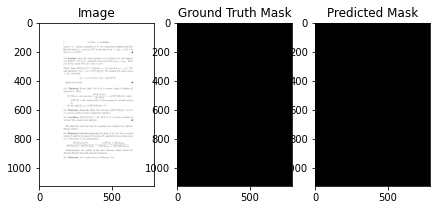

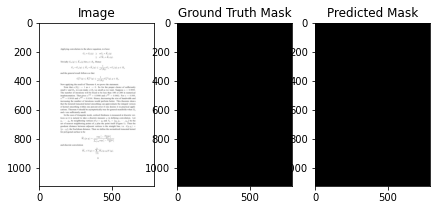

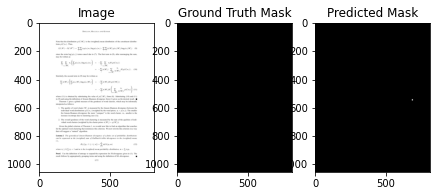

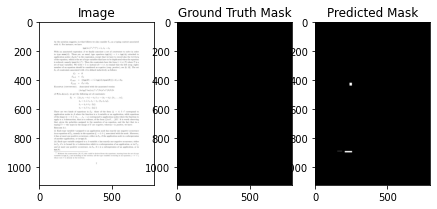

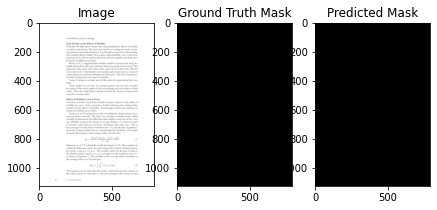

In [ ]:
# IoU Nan
for id in df_nan.iloc[:5]["id"].values:
  plot_masks(id)

## **Observations**

**Distribution of the scores**
- We can see that out distribution of IoU scores is skewed towards the left i.e most values fall on the right side. This is a good thing as we can see that most scores are > 0.4 and very few scores < 0.3. Generally, IoU score of 0.5 is considered fairly good.
- We categorize our samples into categories based on the IoU scores
      1.Best : IoU score > 0.7
      2.Average : IoU score between 0.4 and 0.7
      3.Worst : IoU score < 0.4

- We see that out of 467 samples 87% of the images belonged to Best category, 12% in the average and only 1% in the worst category. This seems like a fairly good distribution in our case.

**Looking at images in the categories**
1. **BEST**
  - Most of these images have only 1 table
  - The tables are larger in size and occupy a mmajor part of the iamge size.
  - Also, when we look at the actual image as the size of the tables are large, there is very less text in the image exclusing the tables.

2. **AVERAGE**
  - We have multiple tables in a single image
  - Compared to BEST cases, the table sizes are significatly smaller.
  - Our model fails in cases where tables are adjacent to once another. In such cases we see that our model combines the masks of adjacent tables into one single table.
  - In some cases whitespace surrounding a table is also predicted as mask, because of which the predicted mask is slightly larger than the ground truth masks.

3. **WORST CASES**
  - We see that if table sizes are very small i.e small height, the our models fails to predict the masks properly.

4. **IoU = 0 or NaN**

  - As we assumed before that if IoU score is NaN or 0 its because there were no tables in the image. When we plot the images with IoU as NaN we see the same.
  - For some images we see that even though there were no tables, some tiny dots were predicted becuase of which IoU was 0.0


# Inference Pipeline

In [ ]:
os.mkdir("./temp")
os.mkdir("./output")

In [ ]:
# Save data into respective CSV Files
def save_to_csv(csv_name,data):
  delim = " "
  if data.find(",") != -1:
    delim = ","
  elif data.find("|") != -1:
    delim = "|"

  data_arr = data.split("\n")
  data_arr = [arr for arr in data_arr if len(arr.strip()) != 0]
  with open(csv_name+".csv",'w') as file:
    for line in data_arr:
      line = line.replace(delim,",")
      file.write(line+"\n")
    file.close()


In [ ]:
#  Given masked image, Save both tables and extract text from each
def extract_text(img_path="temp/final_masked.jpeg"):
  print("Extracting Text....")
  img = cv2.imread(img_path,0)
  org_img = img
  img = cv2.GaussianBlur(img,(10,10),0)
  img = cv2.threshold(img, 0,255, cv2.THRESH_BINARY)[1]
  kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

  _, threshold = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY_INV)
  contours,_ = cv2.findContours(threshold, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
  idx = 1
  for cnt in contours:
    file_name = "output/Table_"+str(idx)
    x,y,w,h = cv2.boundingRect(cnt)
    if x==0 or y==0 or w*h < 20000:
        continue

    roi = org_img[y:y+h, x:x+w]
    roi = cv2.filter2D(roi, -1, kernel)
    roi = cv2.resize(roi, (int(w*1.25),int(h*1.25)), interpolation = cv2.INTER_AREA)
    cv2_imshow(roi)
    data = pytesseract.image_to_string(roi,config='--psm 6',lang='eng')
    print("Extracted Text: ",data)
    cv2.imwrite(file_name+".jpeg",roi) 
    save_to_csv(file_name,data)

    idx += 1
  

In [ ]:
# predict table and column masks and display
def predict_table_masks(img):
  res1, res2 = model.predict(np.array([img]))
  res1 =  np.expand_dims(np.argmax(res1[0], axis=-1), axis=-1)
  res2 = np.expand_dims(np.argmax(res2[0], axis=-1), axis=-1)
  pred_col = np.squeeze(np.where(res1==1,255,0))
  pred_table = np.squeeze(np.where(res2==1,255,0))

  fig, ax = plt.subplots(1,2,figsize=(7,7))
  ax[0].imshow(pred_table)
  ax[0].title.set_text("Predicted Table")
  ax[1].imshow(fil_approx_boxes(pred_table))
  ax[1].title.set_text("Proccsed Mask")
  plt.show()

  return fil_approx_boxes(pred_table),fil_approx_boxes(pred_col)


In [ ]:
# Predict masks and extract text
def predict_and_extract(img_path):
  for file_name in os.listdir("output"):
    os.remove("output/"+file_name)

  image = tf.io.read_file(img_path)
  org_image = tf.image.decode_image(image, channels=3)
  h,w = org_image.shape[0],org_image.shape[1]

  image = tf.image.resize(org_image, [800, 800])
  cv2_imshow(cv2.resize(cv2.imread(img_path),(600,600)))
  pred_table, pred_col = predict_table_masks(image)
  tab = np.where(pred_table == 0,0,1)
  mask = np.expand_dims(tab,axis=2)
  mask = np.concatenate((mask,mask,mask),axis=2)
  cv2.imwrite("temp/mask.jpeg",mask)

  mask = cv2.resize(cv2.imread("temp/mask.jpeg"), (w,h), interpolation = cv2.INTER_AREA)
  masked_img= org_image.numpy() * mask
  cv2_imshow(masked_img)
  cv2.imwrite("temp/final_masked.jpeg",masked_img)
  extract_text()
  shutil.make_archive('output', 'zip', "output/")


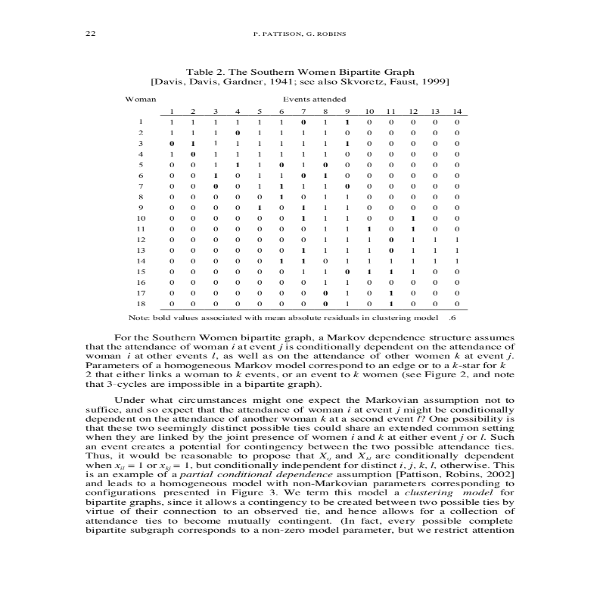

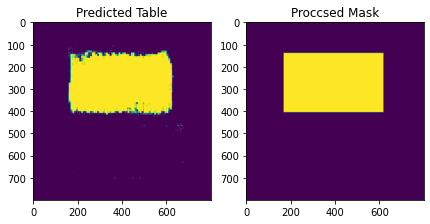

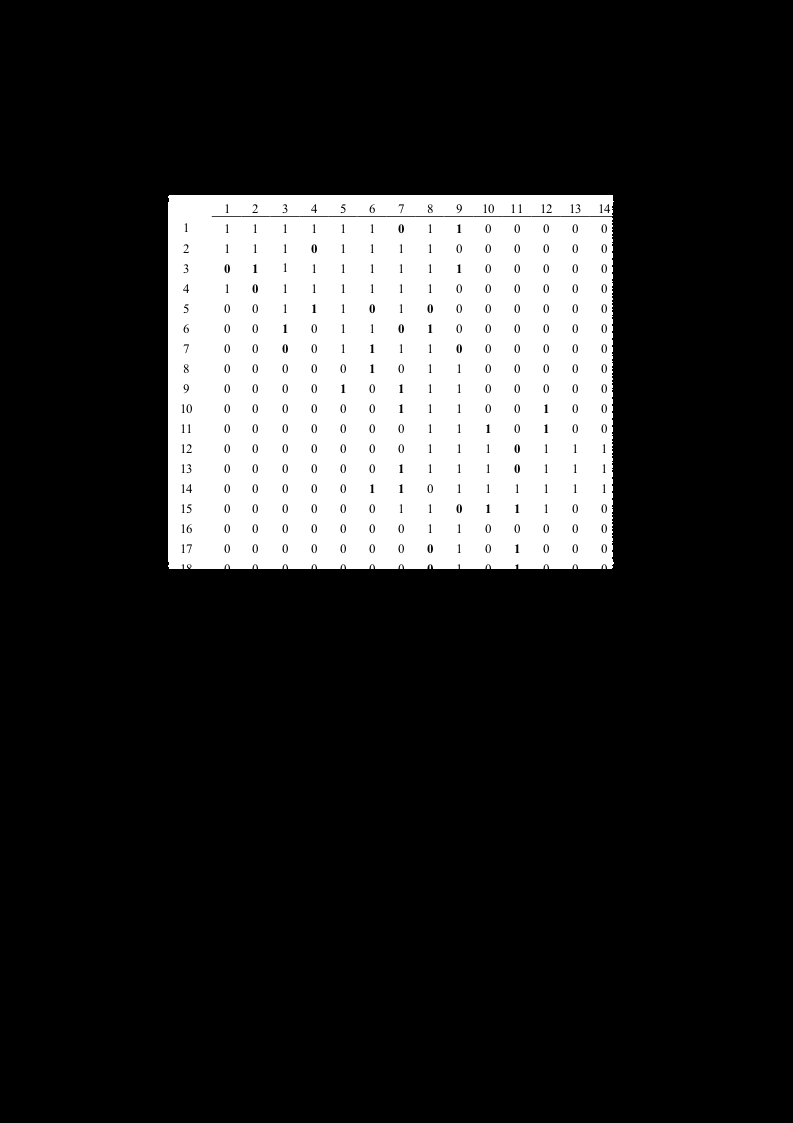

Extracting Text....


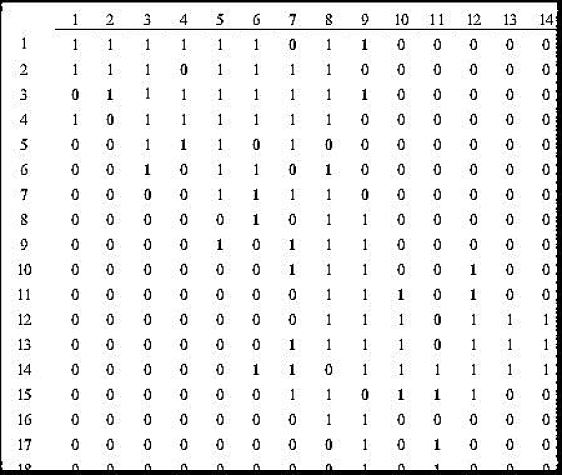

Extracted Text:  1203 4 5 G6 7 8 9 0 1 2 1 14
1 11 1 1 1 1 0 1 1 0 0 0 0 0
2 1 1 1 0 1 1 14 1 06 0 0 0 0 0
3 o i111 1 1 1 1 1 0 0 0 8 0
4 1 0 1 1 1 1 14 1 06 0 0 0 0 0
5 oo 1 1 1 0 1 0 06 09 6 09 0 0
6 oo 1 0 1 1 0 1 0 09 6 0 0 0
1 oo 0 0 1 12 1 1 0 89 6 09 8 0
g 0 0 60 0 0 1 0 1 1 09 6 09 8 0
9 oo 0 0 1 © 1 1 1 09 06 09 0 0
1 9 09 0 © 0 © 1 1 106 0 1 0 0
ret oo 0 0 0 © © 1 1 141 0 1 0 0
2 9 09 0 9 0 © 9 1 1 1 0 1 1 1
3 9 09 09 0 0 © 21 1 1 1 0 1 1 1
4 9 09 0 09 O09 1 2 0 1 1 2 2 1 1
5% Oo 09 09 © 0 © 1 1 0 1 1 1 0 0
6 9 09 09 0 0 © 09 1 106 0 6 0 0
7 9 09 9 09 0 © 0 0 1 6 1 06 08 8



In [ ]:
predict_and_extract("TEMP3.bmp")

In the output folder we would get individual images of all the individual tables as well as the csv files containing the extracted csv files.

In [ ]:
!jupyter nbconvert --to html "/content/CS2_Flask_Server.ipynb"

[NbConvertApp] Converting notebook /content/CS2_Flask_Server.ipynb to html
[NbConvertApp] Writing 312193 bytes to /content/CS2_Flask_Server.html
